In [1]:
import pandas as pd
import numpy as np


%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
# data = pd.DataFrame()

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
data = pd.read_csv('magic_stompy2018.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

In [4]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', 1)
data.set_value(now, 'life', 20)
data.set_value(now, 'opponents_life', 0)
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', 2)
data.set_value(now, 'land rating', 3)
data.set_value(now, 'archetype', 'izzet')

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'initiates companion', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'old growth dryads', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'ripjaw raptor', 0)
data.set_value(now, 'steel life champion', 1)
data.set_value(now, 'thorn lieutenant', 0)
data.set_value(now, 'thrashing brontodon', 1)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'adventurous impulse', 1)
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 1)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 1)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 2)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')

In [5]:
data.mean()

won                        0.534247
life                       8.527397
opponents_life             8.383562
deck_size                 60.000000
starting lands             2.767123
druid of the cowl          0.095890
llanowar elves             0.849315
steel life champion        0.876712
vine mare                  0.849315
blanchwood armor           0.082192
lifecrafters bestiary      0.219178
natures way                0.095890
plummet                    0.178082
rabid bite                 0.452055
titanic growth             0.123288
verdant rebirth            0.150685
gigantosaurus              0.301370
majestic myriarch          0.095890
verdurous gearhulk         0.068493
scaled behemoth            0.068493
ghalta                     0.260274
land rating                2.986301
walking ballista           0.109589
colossal majesty           0.383562
aggressive mamoth          0.000000
rhonas                     0.383562
mouth                      0.000000
blossoming defense         0

In [16]:
# creatures = ['oketra', 'rhonas', 'serpopard', 'pacifist', 'baloth pup', 'mouth', 'croc',
# 'exemplar', 'defiant greatmaw', 'glorybound initiate', 'initiates companion',]

# removal = ['gideons reproach', 'reprisal', 'declare in stone', 'prepare']

# data['creatures_total'] = data[creatures].sum(axis=1)
# data['removal_total'] = data[removal].sum(axis=1)

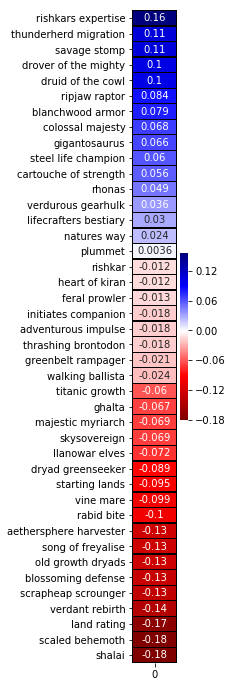

In [6]:
meta_stats = ['won', 'life', 'archetype', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

winning_cards = data[cards].corrwith(data['won'])
winning_cards = pd.DataFrame(winning_cards).dropna().sort_values(0, ascending=False)

plt.figure(figsize=(1,12))

sns.heatmap(winning_cards,
           annot=True, cmap='seismic_r', linecolor='black',
           linewidths=.25, center=0)

In [7]:
from scipy import stats
sleep = []
for i in data.select_dtypes(include=[np.number]).drop(['life', 'opponents_life'], axis=1).columns:
    c = stats.pearsonr(data['won'], data[i])
    if c[1] < .15:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
0,scaled behemoth,-0.181697,0.123935
2,shalai,-0.181697,0.123935
1,land rating,-0.171381,0.147126


In [8]:
cards = [
    'drover of the mighty',
    'druid of the cowl',
    'feral prowler',
    'dryad greenseeker',
    'greenbelt rampager',
    'initiates companion',
    'llanowar elves',
    'mouth',
    'old growth dryads',
    'rishkar',
    'steel life champion',
    'thrashing brontodon',
    'vine mare',
    'walking ballista',
    'aethersphere harvester',
    'lifecrafters bestiary',
    'skysovereign',
    'scrapheap scrounger',
    'heart of kiran',
    'adventurous impulse',
    'blanchwood armor',
    'blossoming defense',
    'cartouche of strength',
    'colossal majesty',
    'natures way',
    'plummet',
    'rabid bite',
    'rishkars expertise',
    'savage stomp',
    'song of freyalise',
    'thunderherd migration',
    'titanic growth',
    'verdant rebirth',
    'vivien reid',
    'aggressive mamoth',
    'ghalta',
    'gigantosaurus',
    'majestic myriarch',
    'rhonas',
    'scaled behemoth',
    'shalai',
    'thorn lieutenant',
    'verdurous gearhulk',
]

In [84]:
combinations = pd.DataFrame()

for i in cards:
    for j in cards:
        if i > j:
            combinations[i + ' + ' + j] = data[i] + data[j]

In [85]:
from scipy import stats
sleep = []
for i in combinations.columns:
    c = stats.pearsonr(data['won'], combinations[i])
    if c[1] < .1:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
10,shalai + scaled behemoth,-0.260273,0.028372
6,verdant rebirth + shalai,-0.225251,0.058938
3,titanic growth + scaled behemoth,-0.223389,0.061118
4,titanic growth + shalai,-0.223389,0.061118
0,song of freyalise + scaled behemoth,-0.215578,0.070990
7,scaled behemoth + old growth dryads,-0.215578,0.070990
1,song of freyalise + shalai,-0.215578,0.070990
8,shalai + old growth dryads,-0.215578,0.070990
5,verdant rebirth + scaled behemoth,-0.209017,0.080234
9,shalai + scrapheap scrounger,-0.204854,0.086581


In [17]:
# Machine learning

In [90]:
x = data[cards]
y = data['won']

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,21),
    'min_samples_leaf': [1,2,3,4,5,10],
    'min_samples_split': np.arange(2,6),
}

clf = DecisionTreeClassifier()

grid = GridSearchCV(clf, param_grid=param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

print('Mean:', cv.mean())
print('Std dev:', cv.std())

Mean: 0.43589743589743596
Std dev: 0.02330638083429049


# Template

In [88]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', )
data.set_value(now, 'life', )
data.set_value(now, 'opponents_life', )
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', )
data.set_value(now, 'land rating', )
data.set_value(now, 'archetype', '')

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'initiates companion', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'old growth dryads', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'ripjaw raptor', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thorn lieutenant', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'adventurous impulse', 0)
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 0)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 0)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')